## 회고
- 디코더 인코더 부분을 좀 더 공부해보고 전처리 역시 내가 직접 코드 하나씩 넣어서 해봐야겠다는 생각이 들었다.

임포트

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')    # WordNet 데이터 다운로드
nltk.download('omw-1.4')    # WordNet의 다국어 지원 데이터 다운로드

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from importlib.metadata import version
import tensorflow
import summa

nltk.download('stopwords')

print(nltk.__version__)
print(tensorflow.__version__)
print(pd.__version__)
print(version('summa'))

3.6.5
2.6.0
1.3.3
1.2.0


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /aiffel/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /aiffel/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
# 데이터셋 다운로드
url = "https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv"
filename = "news_summary_more.csv"
urllib.request.urlretrieve(url, filename)

# 데이터셋 로드
data = pd.read_csv(filename, encoding='iso-8859-1')
print(data.head())

                                           headlines  \
0  upGrad learner switches to career in ML & Al w...   
1  Delhi techie wins free food from Swiggy for on...   
2  New Zealand end Rohit Sharma-led India's 12-ma...   
3  Aegon life iTerm insurance plan helps customer...   
4  Have known Hirani for yrs, what if MeToo claim...   

                                                text  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's...  
1  Kunal Shah's credit card bill payment platform...  
2  New Zealand defeated India by 8 wickets in the...  
3  With Aegon Life iTerm Insurance plan, customer...  
4  Speaking about the sexual harassment allegatio...  


In [7]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98401


칼럼이 headlines과 text로 구성

In [8]:
data.sample(15)

,headlines,text
89476,Elon Musk names his tunnel startup's boring ma...,Elon Musk on Thursday took to Twitter to annou...
98010,I used to think I was a ragpicker as a child: ...,"Anushka Sharma has said that as a child, she u..."
34389,Indian agencies seek ban on Bitcoin trading: R...,The Enforcement Directorate and the Central Bo...
58997,I'll start laughing if I do romantic scenes li...,Comedian Kapil Sharma has said that he will st...
88504,Supreme Court reserves order in triple talaq case,Hearing the pleas challenging the constitution...
75002,Saudi Crown Prince 'wants out' of Yemen war: R...,Saudi Arabia's Crown Prince Mohammed bin Salma...
46198,School girl kills self after alleged molestati...,A Class 7 girl in Uttar Pradesh's Varanasi com...
12711,Protesters clash with police at Amritsar train...,A video showing protesters clash with policeme...
77024,"Bolt wins 100m heats, describes performance as...","Eight-time Olympic gold winner Usain Bolt, who..."
14264,Leader who offered Ã¢ÂÂ¹10cr for Deepika's he...,BJP leader Suraj Pal Amu has claimed that Hary...


In [9]:
data = data[['headlines', 'text']]
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


## 데이터 전처리하기(데이터 정리)

데이터의 중복 샘플 유무를 확인

In [10]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


중복 샘플을 제거

In [11]:
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


 Null 값이 있는지 확인

In [12]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


텍스트 정규화

In [14]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


불용어는 총 198개

In [15]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "

In [16]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [17]:
# 전체 text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 

clean_text = list(data['text'].map(lambda sentence: preprocess_sentence(sentence, remove_stopwords=True)))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [18]:
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
clean_headlines = list(data['headlines'].map(lambda sentence: preprocess_sentence(sentence, remove_stopwords=False)))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [19]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [20]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [21]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


text와 headlines의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


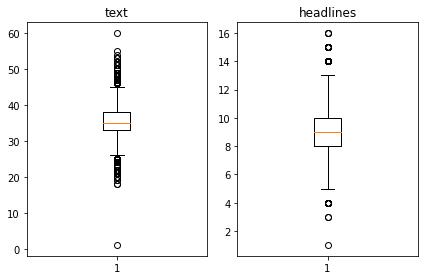

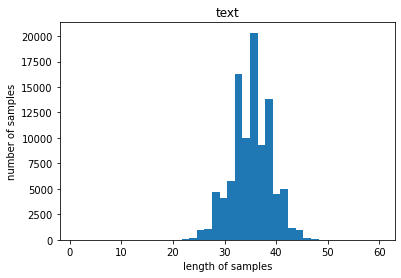

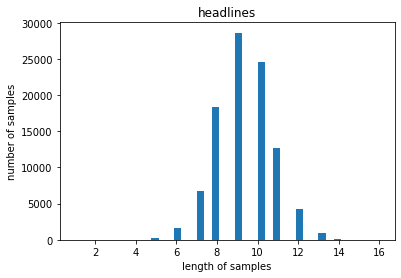

In [22]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

Text의 최대 길이와 Summary의 적절한 최대 길이를 임의로 정해볼게요.

In [23]:
text_max_len = 50
headlines_max_len = 8

훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단

In [24]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

Text와 Summary에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지

In [25]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9998576657177715
전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.2755693371289142


Text와 Summary를 담고 있는 data 데이터프레임을 위에서 임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외하는 코드

In [26]:
data = data[
    (data['text'].apply(lambda x: len(x.split())) <= text_max_len) &
    (data['headlines'].apply(lambda x: len(x.split())) <= headlines_max_len)
]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 27105


- 시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 거예요. 
- 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 
- 두 개의 문장 모두 Summary 열로부터 만들 거예요.

In [27]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
19,odisha cm patnaik controls mining mafia union ...,union minister dharmendra pradhan wednesday cl...,sostoken odisha cm patnaik controls mining maf...,odisha cm patnaik controls mining mafia union ...
21,isro unveils bengaluru centre for manned space...,indian space research organisation wednesday u...,sostoken isro unveils bengaluru centre for man...,isro unveils bengaluru centre for manned space...
22,killed injured in saudi arabia floods,least people killed others injured saudi arabi...,sostoken killed injured in saudi arabia floods,killed injured in saudi arabia floods eostoken
29,seat cushions from missing plane carrying foot...,investigators searching lost plane carrying ar...,sostoken seat cushions from missing plane carr...,seat cushions from missing plane carrying foot...
36,agustawestland scam accused rajiv saxena extra...,agustawestland chopper scam co accused rajiv s...,sostoken agustawestland scam accused rajiv sax...,agustawestland scam accused rajiv saxena extra...


인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장

In [28]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스

In [29]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 9262 14405 10521 ... 21026 11190 18385]


정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플

In [30]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


- 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요. 
- 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의

In [31]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 5421


정의한 테스트 데이터의 개수를 이용해 전체 데이터를 양분

In [32]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 21684
훈련 레이블의 개수 : 21684
테스트 데이터의 개수 : 5421
테스트 레이블의 개수 : 5421


이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 해요. 이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요해요. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현해요. 훈련 데이터에 대해서 단어 집합을 만들어볼게요. 우선, 원문에 해당되는 encoder_input_train에 대해서 단어 집합을 만들게요.

Keras의 토크나이저를 사용하면, 입력된 훈련 데이터로부터 단어 집합을 만들 수 있어요.

In [33]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었어요. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 해요.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼게요.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보

In [34]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 42568
등장 빈도가 6번 이하인 희귀 단어의 수: 30814
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11754
단어 집합에서 희귀 단어의 비율: 72.38770907724113
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.306624001851029


encoder_input_train에는 4만여 개의 단어

등장 빈도가  6회 이하인 단어들은 단어 집합에서 무려 72% 이상을 차지
실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 8.29%

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 1,1731개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 1,1000으로 제한해볼게요. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있어요.

In [35]:
src_vocab = 11000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 11,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [36]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[282, 2216, 122, 29, 526, 2217, 1642, 10767, 1140, 3103, 88, 779, 2928, 2832, 1844, 282, 1, 1147, 1915, 2284, 3104, 1011, 5998, 5251, 7404, 302, 461, 200, 2928, 6494, 200, 1822, 1897, 2637, 2726], [4915, 7808, 1, 357, 1770, 5252, 14, 708, 1680, 265, 295, 8719, 3683, 6, 7, 593, 127, 1345, 357, 3042, 3209, 637, 3154, 127, 7065, 418, 543, 321, 4915, 1], [131, 661, 2599, 3382, 9972, 8720, 291, 8232, 3448, 279, 14, 33, 273, 131, 647, 1078, 912, 14, 807, 439, 372, 807, 1078, 1915, 1725, 277, 1]]


Summary 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산

In [37]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [38]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 18854
등장 빈도가 5번 이하인 희귀 단어의 수: 14226
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 4628
단어 집합에서 희귀 단어의 비율: 75.4534846716877
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 14.22839886932315


등장 빈도가 5회 이하인 단어들은 단어 집합에서 약 75%를 차지하고 있네요. 
훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 14.2%
아까 했던 것과 동일하게 이 단어들은 모두 제거할게요. 어림잡아 4,000을 단어 집합의 크기로 제한

In [39]:
tar_vocab = 4000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 230, 1934, 3332, 671, 3], [1, 136, 1198, 3, 534, 3685], [1, 173, 572, 6, 1062, 85, 1461], [1, 519, 825, 3686, 983, 546, 366, 1313], [1, 472, 192, 2205, 504, 2206, 23, 775]]
target
decoder  [[230, 1934, 3332, 671, 3, 2], [136, 1198, 3, 534, 3685, 2], [173, 572, 6, 1062, 85, 1461, 2], [519, 825, 3686, 983, 546, 366, 1313, 2], [472, 192, 2205, 504, 2206, 23, 775, 2]]


전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있어요. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 4밖에 되지 않았던 요약문(Summary)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높겠죠.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [40]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 21682
훈련 레이블의 개수 : 21682
테스트 데이터의 개수 : 5420
테스트 레이블의 개수 : 5420


- 패딩하기
    - 텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요. 아까 정해두었던 최대 길이로 패딩 해 줄 거에요. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

In [41]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


## 모델 설계하기
우선 함수형 API를 이용해서 인코더를 설계

In [42]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)
encoder_outputs = encoder_output3 

디코더 설계

In [43]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [44]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1408000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

- 어텐션 메커니즘
    - 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정
    - 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

In [45]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 128)      1408000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 훈련하기

In [46]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
85/85 [==============================] - 32s 81ms/step - loss: 5.9894 - val_loss: 5.5729
Epoch 2/50
85/85 [==============================] - 6s 67ms/step - loss: 5.5584 - val_loss: 5.3023
Epoch 3/50
85/85 [==============================] - 6s 68ms/step - loss: 5.3386 - val_loss: 5.2020
Epoch 4/50
85/85 [==============================] - 6s 69ms/step - loss: 5.1823 - val_loss: 5.0710
Epoch 5/50
85/85 [==============================] - 6s 69ms/step - loss: 5.0250 - val_loss: 4.9551
Epoch 6/50
85/85 [==============================] - 6s 69ms/step - loss: 4.8770 - val_loss: 4.8368
Epoch 7/50
85/85 [==============================] - 6s 69ms/step - loss: 4.7271 - val_loss: 4.7501
Epoch 8/50
85/85 [==============================] - 6s 70ms/step - loss: 4.5699 - val_loss: 4.6435
Epoch 9/50
85/85 [==============================] - 6s 71ms/step - loss: 4.4293 - val_loss: 4.5563
Epoch 10/50
85/85 [==============================] - 6s 71ms/step - loss: 4.2999 - val_loss: 4.5017
Epoch 11

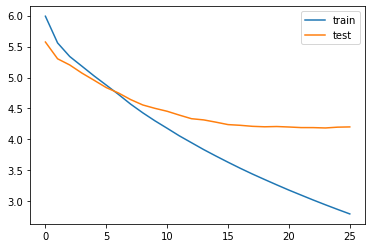

In [47]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [60]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [61]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [62]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


In [66]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


In [67]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp = ''
    for i in input_seq:
        if (i != 0 and i != tar_word_to_index['sostoken']) and (i != tar_word_to_index['eostoken']):
            temp += tar_index_to_word[i] + ' '
    return temp.strip()

print('=3')

=3


In [68]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : delhi high court sought response rbi plea challenging circular prohibits banks providing service businesses dealing cryptocurrencies gujarat based digital proposed launch crypto exchange filed plea company sought rbi order grounds unconstitutional 
실제 요약 : rbi order on cryptocurrencies challenged in delhi hc
예측 요약 :  rbi governor to insolvency applications


원문 : group hindu activists allegedly disrupted christmas celebrations rajasthan town tuesday night claiming event aimed forcibly converting attendees organisers said police allowed event refused provide written permission police said event held illegally 
실제 요약 : hindu activists christmas celebrations in rajasthan
예측 요약 :  kerala police protest against against


원문 : dutch researcher proposed making three planes take land simultaneously planes could take custom locations circle avoid destination circular runway would make airports smaller banking runway would ensure less fuel usage wear 
실제 요약 : researcher proposes for airport

### 잘 나왔다고 생각하는 부분

- 원문 : fire broke factory noida sector burst wednesday fire spread quickly due wind presence materials including officials said workers inside factory fire started one hurt 
- 실제 요약 : fire breaks out at factory in noida
- 예측 요약 :  injured in fire at fire

-  : 화재가 발생한 공장 노이다 부문이 수요일 화재가 빠르게 확산되었습니다. 이는 공장 화재 내부의 근로자들이 한 명의 부상을 입었다고 관계자들을 포함한 바람 존재 물질로 인해 발생했습니다
- 실제 요약 : 노이다 공장에서 화재 발생
- 예측 요약 : 화재로 부상당함

- 원문 : international credit rating agency standard poor friday kept india sovereign rating unchanged lowest investment grade rating bonds retained outlook india rating stable agency lauded government fiscal drive said reforms undertaken economy 
- 실제 요약 : keeps india rating at
- 예측 요약 :  india gdp growth to india

- 원문 : 국제 신용 평가 기관의 표준 부진한 금요일 인도 국가 신용 등급은 변경되지 않았으며 최저 투자 등급 채권은 전망 유지 인도 신용 등급 안정 기관은 정부 재정 추진에 찬사를 보냈습니다. 개혁이 진행된 경제에 영향을 미쳤다고 말했습니다
- 실제 요약 : 인도 등급 유지
- 예측 요약 : 인도 GDP 성장률

- 원문 : former rashtriya janata dal mp mohammad acquitted jamshedpur court triple murder case took place february notably three eight accused died trial linked criminal cases currently lodged delhi high security tihar jail 
- 실제 요약 : leader acquitted in triple murder case
- 예측 요약 :  former leader arrested in case

- 원문 : 전 라슈트리야 자나타 달 의원 모하마드 무죄 판결을 받은 잠셰드푸르 법원 삼중 살인 사건이 2월에 발생했으며, 특히 현재 델리 고등 보안 티하르 감옥에 수감 중인 8건의 피고인 사망 재판 관련 형사 사건이 3건 발생했습니다
- 실제 요약 : 세 건의 살인 사건에서 무죄 판결을 받은 지도자
- 예측 요약 : 전 지도자 체포 사건